<a href="https://colab.research.google.com/github/shilz1007/shilz1007/blob/main/PointNet_ModelNet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 663 kB 9.3 MB/s 


In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Model,activations
from tensorflow.keras.layers import Activation,Dense,Flatten,Conv1D,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import Regularizer
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

Downloading ModelNet10 dataset.

In [ ]:
Data_ModelNet = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)                        
Data_ModelNet = os.path.join(os.path.dirname(Data_ModelNet), "ModelNet10")                                        

473402300/473402300 [==============================] - 12s 0us/step


In [ ]:
mesh = trimesh.load(os.path.join(Data_ModelNet,"chair/train/chair_0370.off"))
mesh.show()

In [ ]:
mesh = trimesh.load(os.path.join(Data_ModelNet,"bed/train/bed_0001.off"))
mesh.show()

In [ ]:
mesh = trimesh.load(os.path.join(Data_ModelNet,"bathtub/train/bathtub_0001.off"))
mesh.show()

In [ ]:
mesh = trimesh.load(os.path.join(Data_ModelNet,"desk/train/desk_0001.off"))
mesh.show()

In [ ]:
mesh = trimesh.load(os.path.join(Data_ModelNet,"dresser/train/dresser_0001.off"))
mesh.show()

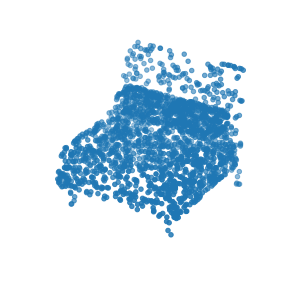

In [ ]:
points = mesh.sample(2048)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
def create_test_train(num_points=2048):
  print('inside')
  train_points = []
  train_labels = []
  test_points  = []
  test_labels  = []
  class_map = {}
  folders = glob.glob(os.path.join(Data_ModelNet,"[!README]*"))
  #print(folders)

  for i, folder in enumerate(folders):
    #print("processing class: {}".format(os.path.basename(folder)))
    class_map[i] = folder.split("/")[-1]
    #print(class_map[i])
    train_files = glob.glob(os.path.join(folder,"train/*"))
    test_files = glob.glob(os.path.join(folder,"test/*"))

    for f in train_files:
      train_points.append(trimesh.load(f).sample(num_points))
      train_labels.append(i)

    for f in test_files:
      test_points.append(trimesh.load(f).sample(num_points))
      test_labels.append(i)

  print(class_map)
  return(
      np.array(train_points),
      np.array(test_points),
      np.array(train_labels),
      np.array(test_labels),
      class_map,
  )      

In [ ]:
points = 2048
classes = 10
batch_size = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = create_test_train(points)

inside
{0: 'toilet', 1: 'night_stand', 2: 'dresser', 3: 'sofa', 4: 'monitor', 5: 'table', 6: 'bed', 7: 'chair', 8: 'bathtub', 9: 'desk'}


In [ ]:
for i in range(10):
  print(CLASS_MAP[i])

toilet
night_stand
dresser
sofa
monitor
table
bed
chair
bathtub
desk


In [ ]:
def augment(points,labels):
  points += tf.random.uniform(points.shape,-0.005,0.005,dtype=tf.float64)
  points = tf.random.shuffle(points)
  return points,labels

train_dataset = tf.data.Dataset.from_tensor_slices((train_points,train_labels))
test_dataset =  tf.data.Dataset.from_tensor_slices((test_points,test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(batch_size)
test_dataset = test_dataset.shuffle(len(test_points)).batch(batch_size)

In [ ]:
def conv_layer(x,filters):
  x = layers.Conv1D(filters,kernel_size=1,padding='valid')(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation('relu')(x)

def dense_layers(x,filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = tf.keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_layer(inputs, 64)
    x = conv_layer(x, 64)
    x = conv_layer(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_layers(x, 256)
    x = dense_layers(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = tf.keras.Input(shape=(points, 3))

x = tnet(inputs, 3)
x = conv_layer(x, 64)
x = conv_layer(x, 64)
x = tnet(x, 64)
x = conv_layer(x, 64)
x = conv_layer(x, 256)
x = conv_layer(x, 1024)
x = layers.GlobalMaxPooling1D()(x)
x = dense_layers(x, 512)
x = layers.Dropout(0.3)(x)
x = dense_layers(x, 256)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(classes, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 2048, 64)     256         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_46 (BatchN  (None, 2048, 64)    256         ['conv1d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_46 (Activation)     (None, 2048, 64)     0           ['batch_normalization_46[0

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)



In [ ]:
#model.fit(train_dataset, epochs=20, validation_data=test_dataset)
model.fit(train_dataset,epochs=30,validation_data=test_dataset)

Epoch 1/30
125/125 [==============================] - 8s 68ms/step - loss: 2.5439 - sparse_categorical_accuracy: 0.8639 - val_loss: 1154626748416.0000 - val_sparse_categorical_accuracy: 0.8392
Epoch 2/30
125/125 [==============================] - 8s 67ms/step - loss: 2.4543 - sparse_categorical_accuracy: 0.8745 - val_loss: 3410947211264.0000 - val_sparse_categorical_accuracy: 0.8348
Epoch 3/30
125/125 [==============================] - 8s 67ms/step - loss: 2.3934 - sparse_categorical_accuracy: 0.8980 - val_loss: 1369696501760.0000 - val_sparse_categorical_accuracy: 0.8480
Epoch 4/30
125/125 [==============================] - 8s 67ms/step - loss: 2.3809 - sparse_categorical_accuracy: 0.8983 - val_loss: 6363498414080.0000 - val_sparse_categorical_accuracy: 0.8282
Epoch 5/30
125/125 [==============================] - 8s 67ms/step - loss: 2.3562 - sparse_categorical_accuracy: 0.9110 - val_loss: 33359126952148992.0000 - val_sparse_categorical_accuracy: 0.7841
Epoch 6/30
125/125 [===========

Model

In [ ]:
inputs = tf.keras.Input(shape=(points,3))
pointnet = Sequential()
pointnet = tf.keras.layers.Conv1D(64,kernel_size=1,padding='valid')(inputs)
pointnet = tf.keras.layers.BatchNormalization()(pointnet)
pointnet = tf.keras.layers.Activation('relu')(pointnet)
pointnet = tf.keras.layers.Conv1D(128,kernel_size=1,padding='valid')(pointnet)
pointnet = tf.keras.layers.BatchNormalization()(pointnet)
pointnet = tf.keras.layers.Activation('relu')(pointnet)
pointnet = tf.keras.layers.Conv1D(512,kernel_size=1,padding='valid')(pointnet)
pointnet = tf.keras.layers.BatchNormalization()(pointnet)
pointnet = tf.keras.layers.Activation('relu')(pointnet)
pointnet = tf.keras.layers.GlobalMaxPool1D()(pointnet)
pointnet = tf.keras.layers.Flatten()(pointnet)
pointnet = tf.keras.layers.Dense(512,activation='relu')(pointnet)
pointnet = tf.keras.layers.Dropout(0.3)(pointnet)
pointnet = tf.keras.layers.Dense(256,activation='relu')(pointnet)
pointnet = tf.keras.layers.Dropout(0.3)(pointnet)

outputs = tf.keras.layers.Dense(classes,activation='softmax')(pointnet)
model = tf.keras.Model(inputs=inputs,outputs=outputs,name='pointnet')
model.summary()


TypeError: ignored

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=["sparse_categorical_accuracy"])


In [ ]:
model.fit(train_dataset,epochs=25,validation_data=test_dataset)

Epoch 1/25
125/125 [==============================] - 14s 23ms/step - loss: 2.3535 - sparse_categorical_accuracy: 0.3300 - val_loss: 2.5165 - val_sparse_categorical_accuracy: 0.1300
Epoch 2/25
125/125 [==============================] - 3s 21ms/step - loss: 1.4276 - sparse_categorical_accuracy: 0.5174 - val_loss: 2.9177 - val_sparse_categorical_accuracy: 0.1200
Epoch 3/25
125/125 [==============================] - 3s 21ms/step - loss: 1.1536 - sparse_categorical_accuracy: 0.6139 - val_loss: 3.9289 - val_sparse_categorical_accuracy: 0.1300
Epoch 4/25
125/125 [==============================] - 3s 21ms/step - loss: 1.1202 - sparse_categorical_accuracy: 0.6460 - val_loss: 3.6562 - val_sparse_categorical_accuracy: 0.1696
Epoch 5/25
125/125 [==============================] - 3s 21ms/step - loss: 0.9385 - sparse_categorical_accuracy: 0.6828 - val_loss: 3.5185 - val_sparse_categorical_accuracy: 0.1586
Epoch 6/25
125/125 [==============================] - 3s 20ms/step - loss: 0.9230 - sparse_cat

1/1 [==============================] - 0s 23ms/step


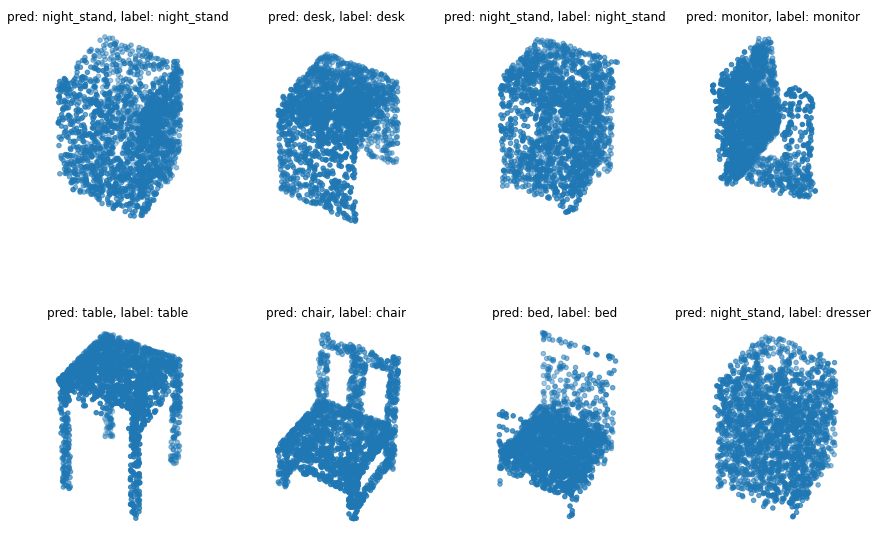

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()